In [1]:
import os
import librosa
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
! pip install pydot graphviz

# Data loading

In [5]:
root='data'
audio_dataset_NoBlock='data/NoStutteredWords'
audio_dataset_Block='data/Block'

In [6]:
Noblock=tf.data.Dataset.list_files(audio_dataset_NoBlock+'\*.wav')
Block=tf.data.Dataset.list_files(audio_dataset_Block+'\*.wav')

In [7]:
bdata = tf.data.Dataset.zip((Block, tf.data.Dataset.from_tensor_slices(tf.ones(len(Block)))))
nbdata = tf.data.Dataset.zip((Noblock, tf.data.Dataset.from_tensor_slices(tf.zeros(len(Noblock)))))
data = bdata.concatenate(nbdata)

In [8]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

# Preprocessing

In [9]:
spectrograms=[]
classes=[]
for item in data:
    audio_data, Class = item
    audio_data = audio_data.numpy().decode('utf-8')
    audio, sample_rate = librosa.load(audio_data)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    spectrograms.append(spectrogram)
    classes.append(Class)

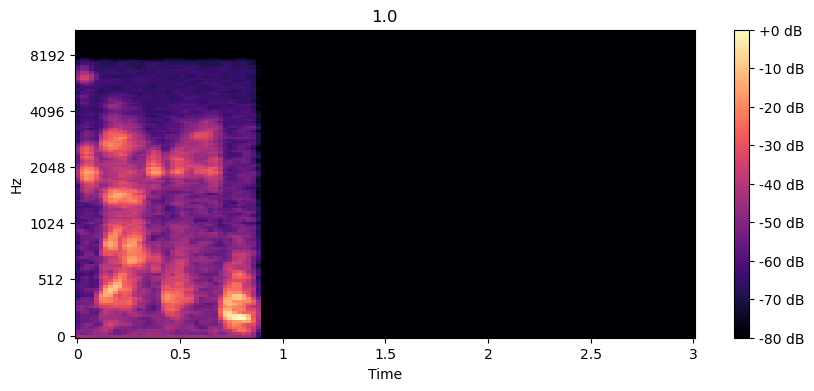

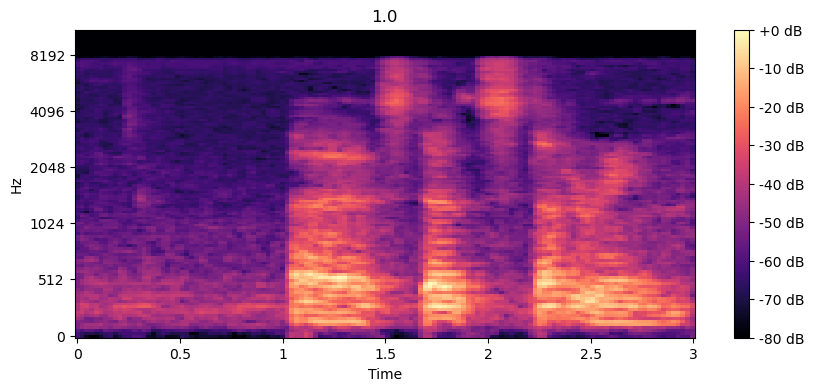

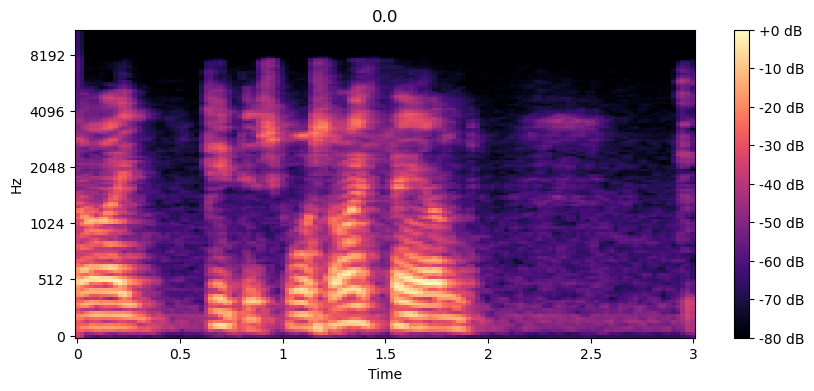

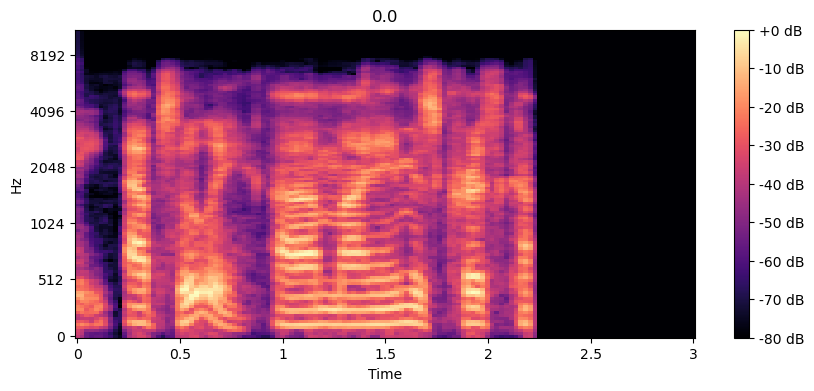

In [10]:
v=[12,35,7665,3467]
for i in v:
    spectrogram_db = librosa.power_to_db(spectrograms[i], ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    class_label = classes[i].numpy()
    plt.title(str(class_label))
    plt.show()

In [11]:
label=[]
for cl in classes:
    label.append(int(cl.numpy()))

In [12]:
for i in range(len(spectrograms)):
    temp = np.expand_dims(spectrograms[i], axis=-1)
    spectrograms[i] = temp
    print(spectrograms[i].shape)
    temp = []

(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 130, 1)
(128, 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(spectrograms, label, test_size=0.2, random_state=42)

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)

(2733, 128, 130, 1)
(10931, 128, 130, 1)
(10931,)
(2733,)


# Model Architecture

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 130, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Reshape for the LSTM layer
model.add(Reshape((30 * 31, 64)))

# LSTM layer
model.add(LSTM(64, return_sequences=True))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 31, 64)        0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 930, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 930, 64)           3

In [4]:
from tensorflow.keras.utils import plot_model

plot_model(model,show_shapes=True,show_layer_names=True, rankdir='TB')
plt.show()

# Training

In [98]:
epoch = 2
batch = 128
history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_data=(X_test, y_test))

Epoch 1/2
86/86 [==============================] - 1125s 13s/step - loss: 0.0523 - accuracy: 0.9801 - val_loss: 1.0273 - val_accuracy: 0.7596
Epoch 2/2
86/86 [==============================] - 1129s 13s/step - loss: 0.0512 - accuracy: 0.9797 - val_loss: 1.0784 - val_accuracy: 0.7629


Epochs - 20 BatchSize - 32

In [28]:
epoch = 20
batch = 32
history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_data=(X_test, y_test))

Epoch 1/20
342/342 [==============================] - 901s 3s/step - loss: 0.5345 - accuracy: 0.7836 - val_loss: 0.4963 - val_accuracy: 0.7867
Epoch 2/20
342/342 [==============================] - 867s 3s/step - loss: 0.5010 - accuracy: 0.7876 - val_loss: 0.4923 - val_accuracy: 0.7863
Epoch 3/20
342/342 [==============================] - 1062s 3s/step - loss: 0.4787 - accuracy: 0.7917 - val_loss: 0.4909 - val_accuracy: 0.7878
Epoch 4/20
342/342 [==============================] - 1049s 3s/step - loss: 0.4405 - accuracy: 0.8003 - val_loss: 0.5085 - val_accuracy: 0.7845
Epoch 5/20
342/342 [==============================] - 1047s 3s/step - loss: 0.3826 - accuracy: 0.8331 - val_loss: 0.5309 - val_accuracy: 0.7775
Epoch 6/20
342/342 [==============================] - 1057s 3s/step - loss: 0.3083 - accuracy: 0.8696 - val_loss: 0.5935 - val_accuracy: 0.7812
Epoch 7/20
342/342 [==============================] - 1071s 3s/step - loss: 0.2292 - accuracy: 0.9071 - val_loss: 0.6893 - val_accuracy: 0

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")
model.save('saved_models/audio_classification_model.h5')

86/86 [==============================] - 78s 900ms/step - loss: 1.1403 - accuracy: 0.7541
Test loss: 1.1403, Test accuracy: 0.7541


c:\Users\DEEPAK KUMAR\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epochs - 10 BatchSize - 32

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")
model.save('saved_models/audio_classification_model(10,32).h5')

Epochs - 5 BatchSize - 64

In [93]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")
model.save('saved_models/audio_classification_model(5,64).h5')

86/86 [==============================] - 49s 572ms/step - loss: 0.8059 - accuracy: 0.7666
Test loss: 0.8059, Test accuracy: 0.7666


Epochs - 5 BatchSize - 128

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")
model.save('saved_models/audio_classification_model(5,128).h5')

86/86 [==============================] - 51s 589ms/step - loss: 0.9764 - accuracy: 0.7622
Test loss: 0.9764, Test accuracy: 0.7622


Epochs - 3 BatchSize - 128

In [97]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")
model.save('saved_models/audio_classification_model(3,128).h5')

86/86 [==============================] - 51s 593ms/step - loss: 1.0148 - accuracy: 0.7640
Test loss: 1.0148, Test accuracy: 0.7640


Epochs - 2 BatchSize - 128

In [99]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")
model.save('saved_models/audio_classification_model(2,128).h5')

86/86 [==============================] - 50s 584ms/step - loss: 1.0784 - accuracy: 0.7629
Test loss: 1.0784, Test accuracy: 0.7629


Epochs - 3 BatchSize - 64

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")
model.save('saved_models/audio_classification_model(3,64).h5')

Epochs - 2 BatchSize - 64

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")
model.save('saved_models/audio_classification_model(2,64).h5')

# Training / Validarion loss accuracy and loss plots

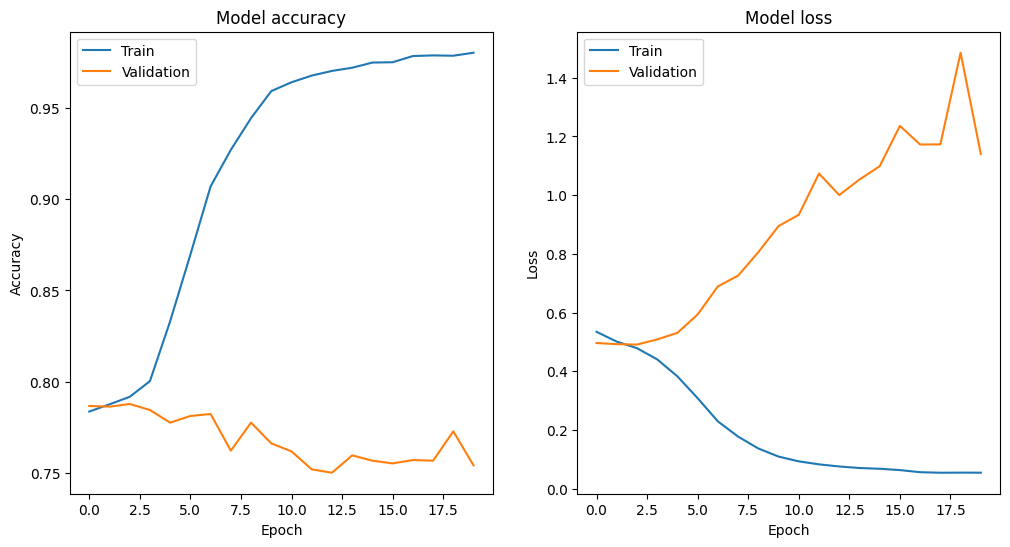

In [30]:
# accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Testing

In [15]:
mod = models.load_model('saved_models/audio_classification_model(20,32).h5')

In [16]:
def Predict(sample):
    audio, sample_rate = librosa.load(sample)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)

    # for visualization
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    # Reshaping to the required inputshape of the model
    input_spectrogram = np.expand_dims(spectrogram, axis=0)
    input_spectrogram = np.expand_dims(input_spectrogram, axis=-1)

    #Prediction
    threshold = 0.5
    predicted_prob = mod.predict(input_spectrogram)
    predicted_class = 1 if predicted_prob[0][0] >= threshold else 0
    if predicted_class:
        print(f"Predicted class: Stuttering(Block)")
    else:
        print(f"Predicted class: No Stuttering")

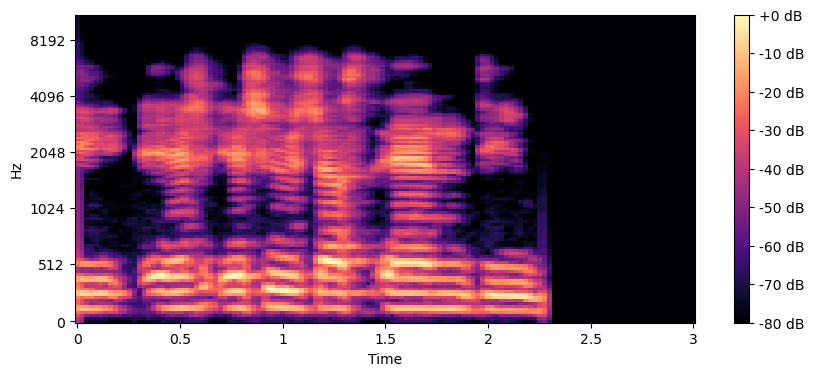

1/1 [==============================] - 1s 1s/step
Predicted class: Stuttering(Block)


In [17]:
# stuttering audio file
Predict('data/Block/StutterTalk_17_8_0.wav')

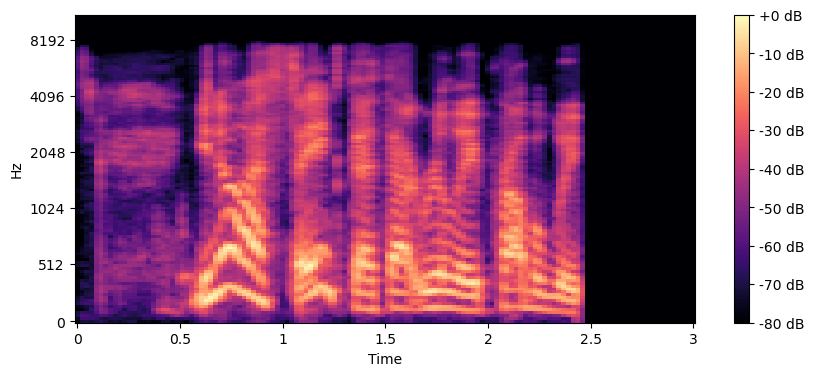

1/1 [==============================] - 0s 130ms/step
Predicted class: No Stuttering


In [18]:
# No stuttering audio file
Predict('data/NoStutteredWords/StutterTalk_23_15_0.wav')